# Assignment: Classification of Fashion Items

In this assignment, you will classify fashion articles from the [MNIST fashion dataset](https://github.com/zalandoresearch/fashion-mnist) using two different tools: a k-nearest neighbor classifier and a dense neural network (multilayer perceptron). The relevant material for this assignment is covered in lectures 8 and 9. The assignment instructions are provided on Canvas.

## Boilerplate Notebook Code

Below, you find the boilerplate code that you have to use for the assignment, including basic instructions.
Note that you may need to change the dependency installation procedure.
Debug by removing the `%%capture` line.
If you use a [virtual environment](https://docs.python.org/3/library/venv.html), make sure you can set the notebook's kernel accordingly (assuming your virtual environment is called `venv`):

```
pip3 install ipykernel
python -m ipykernel install --user --name=venv
```

Then, also remove the flags `--user -Iv` below.

In [1]:
# Set the random seed for reproducible results

import numpy as np
np.random.seed(42)

In [2]:
# Load the Fashion MNIST dataset

import sklearn.datasets
data = sklearn.datasets.fetch_openml("Fashion-MNIST", parser="auto")
print(data.DESCR)

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

In [3]:
# Split the data into training, validation and test

from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(data.data, data.target, test_size=0.25, random_state=1)

# We may alternatively skip this / have a combined Xtrain and Xval here and instead use cross-validation below
Xtest, Xval, ytest, yval = train_test_split(Xtest, ytest, test_size=0.5, random_state=1)
Xtrain =  np.asarray(Xtrain)
Xtest =  np.asarray(Xtest)
Xval =  np.asarray(Xval)
ytrain =  np.asarray(ytrain)
ytest =  np.asarray(ytest)
yval =  np.asarray(yval)

# Do not touch the test data until the end
print(f"Training set size X   : {Xtrain.shape}")
print(f"Training set size y   : {ytrain.shape}")
print(f"Validation set size X : {Xval.shape}")
print(f"Validation set size y : {yval.shape}")
print(f"Test set size X       : {Xtest.shape}")
print(f"Test set size y       : {ytest.shape}")
print(f"Output classes        : {set(ytrain)}")

Training set size X   : (52500, 784)
Training set size y   : (52500,)
Validation set size X : (8750, 784)
Validation set size y : (8750,)
Test set size X       : (8750, 784)
Test set size y       : (8750,)
Output classes        : {'6', '5', '8', '1', '2', '0', '9', '3', '7', '4'}


In [4]:
# Preprocess the data

import sklearn.preprocessing

print(f"Before preprocessing, training data   : " f"min = {np.min(Xtrain):.1f}, " f"max = {np.max(Xtrain):.1f}, " f"mean = {np.mean(Xtrain):.1f}, " f"std = {np.std(Xtrain):.1f}")
print(f"Before preprocessing, validation data : " f"min = {np.min(Xval):.1f}, " f"max = {np.max(Xval):.1f}, " f"mean = {np.mean(Xval):.1f}, " f"std = {np.std(Xval):.1f}")
print(f"Before preprocessing, test data       : " f"min = {np.min(Xtest):.1f}, " f"max = {np.max(Xtest):.1f}, " f"mean = {np.mean(Xtest):.1f}, " f"std = {np.std(Xtest):.1f}")

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(Xtrain)  # Every statistic we compute is found on the training data

Xtrain = scaler.transform(Xtrain)
Xval = scaler.transform(Xval)
# Test data will be transformed at the end, before evaluation to maintain proper separation between development and test sets

print(f"After preprocessing, training data    : " f"min = {np.min(Xtrain):.1f}, " f"max = {np.max(Xtrain):.1f}, " f"mean = {np.mean(Xtrain):.1f}, " f"std = {np.std(Xtrain):.1f}")
print(f"After preprocessing, validation data  : " f"min = {np.min(Xval):.1f}, " f"max = {np.max(Xval):.1f}, " f"mean = {np.mean(Xval):.1f}, " f"std = {np.std(Xval):.1f}")
print(f"Test data will be preprocessed only before final evaluation")

Before preprocessing, training data   : min = 0.0, max = 255.0, mean = 72.9, std = 89.9
Before preprocessing, validation data : min = 0.0, max = 255.0, mean = 73.5, std = 90.3
Before preprocessing, test data       : min = 0.0, max = 255.0, mean = 72.9, std = 90.1
After preprocessing, training data    : min = -1.0, max = 1.0, mean = -0.4, std = 0.7
After preprocessing, validation data  : min = -1.0, max = 1.2, mean = -0.4, std = 0.7
Test data will be preprocessed only before final evaluation


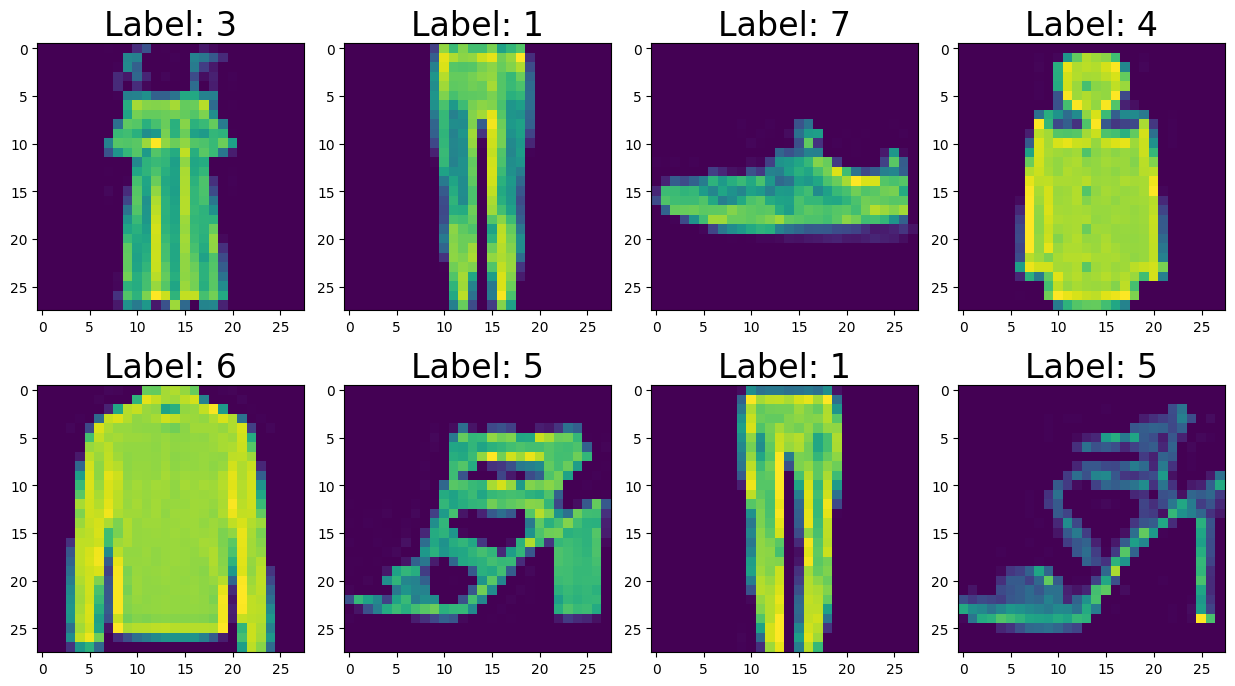

In [5]:
# Plot a few images

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 7.75))
fig.subplots_adjust(top=0.995, bottom=0.115, left=0.005, right=0.995, wspace=0.15, hspace=0.005)

plot_array = (2, 4)
ax = [[None] * plot_array[1]] * plot_array[0]
it = 0
for i in range(plot_array[0]):
    for j in range(plot_array[1]):
        ax[i][j] = plt.subplot2grid((2, 4), (i, j), rowspan=1, colspan=1)
        ax[i][j].imshow(Xtrain[it, :].reshape((28, 28)))
        ax[i][j].set_title(f"Label: {ytrain[it]}", fontsize=24)
        it += 1

### The $k$-NN model

You have to implement the $k$-NN classifier yourself. The below implementation uses the scikit-learn implementation of the $k$-NN classifier, but you need to do it yourself. Also, perform a hyper-parameter search for the optimal number of neighbors, $k$.

#### Implementation Details

The custom k-NN classifier implementation includes:

1. **Distance Metric**: Euclidean distance calculation between data points
2. **Training Phase**: Stores training data (lazy learning approach)
3. **Prediction Phase**: 
   - Calculates distances to all training points
   - Selects k nearest neighbors
   - Uses majority voting for classification
4. **Accuracy Calculation**: Compares predictions with ground truth labels

**Hyperparameter Search Strategy:**
- Test multiple k values: [1, 3, 5, 7, 9, 11, 13, 15]
- Evaluate each configuration on validation set
- Select k with highest validation accuracy
- Trade-off: Lower k → more sensitive to noise, Higher k → smoother decision boundaries

In [6]:
# Create the k-NN classifier

from sklearn.neighbors import KNeighborsClassifier as SKLearnKNN
from collections import Counter

# Custom k-NN classifier implementation
class KNeighborsClassifier:
    """
    Custom implementation of k-Nearest Neighbors classifier.
    Uses Euclidean distance and majority voting for classification.
    Optimized with vectorized operations for better performance.
    """

    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Fit the model by storing the training data.
        For k-NN, training is just storing the data points.
        """
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y)
        return self

    def predict(self, X):
        """
        Predict class labels for all data points in X.
        Uses vectorized operations for efficiency.
        """
        X = np.asarray(X)
        predictions = []

        for x in X:
            # Vectorized distance calculation to all training points at once
            # This is much faster than looping through each training point
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

            # Get indices of k nearest neighbors using argpartition
            # This is O(n) instead of O(n log n) for full sorting
            k_indices = np.argpartition(distances, self.n_neighbors)[: self.n_neighbors]

            # Get labels of k nearest neighbors
            k_nearest_labels = self.y_train[k_indices]

            # Return the most common label (majority vote)
            most_common = Counter(k_nearest_labels).most_common(1)
            predictions.append(most_common[0][0])

        return np.array(predictions)

    def score(self, X, y):
        """
        Calculate the accuracy of predictions.
        """
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

In [7]:
# Perform grid search to find the number of neighbours, K

print("Starting k-NN Grid Search...")
print("=" * 60)

# Define hyperparameter search space
k_values = [1, 3, 5, 7, 9, 11, 13, 15]  # Different values of k to test

# Use a subset of data for faster computation during grid search
# We can adjust these values based on the computer's capabilities
train_subset_size = 10000  # Using 10k training samples for grid search
val_subset_size = 5000  # Using 5k validation samples

knn_errs_val = []  # Changed variable name to avoid conflict with neural network
best_k = 1
best_accuracy = 0

# Grid search loop - trying different values of k
for k in k_values:
    print(f"\nTesting k={k}...")

    # Create model with current k value
    model = KNeighborsClassifier(n_neighbors=k)

    # Fit model on training subset
    print(f"  Training on {train_subset_size} samples...")
    model.fit(Xtrain[:train_subset_size, :], ytrain[:train_subset_size])

    # Evaluate on validation subset
    print(f"  Evaluating on {val_subset_size} validation samples...")
    accuracy = model.score(Xval[:val_subset_size, :], yval[:val_subset_size])
    knn_errs_val.append(accuracy)

    print(f"  Validation accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Track best k value
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        print(f"  *** New best k found: {best_k} with accuracy {best_accuracy:.4f} ***")

print("\n" + "=" * 60)
print("Grid search complete!")
print(f"Best k: {best_k} with validation accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("=" * 60)

Starting k-NN Grid Search...

Testing k=1...
  Training on 10000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8124 (81.24%)
  *** New best k found: 1 with accuracy 0.8124 ***

Testing k=3...
  Training on 10000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8232 (82.32%)
  *** New best k found: 3 with accuracy 0.8232 ***

Testing k=5...
  Training on 10000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8274 (82.74%)
  *** New best k found: 5 with accuracy 0.8274 ***

Testing k=7...
  Training on 10000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8260 (82.60%)

Testing k=9...
  Training on 10000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8252 (82.52%)

Testing k=11...
  Training on 10000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8194 (81.94%)

Testing k=13...
  Training on 10000 sample

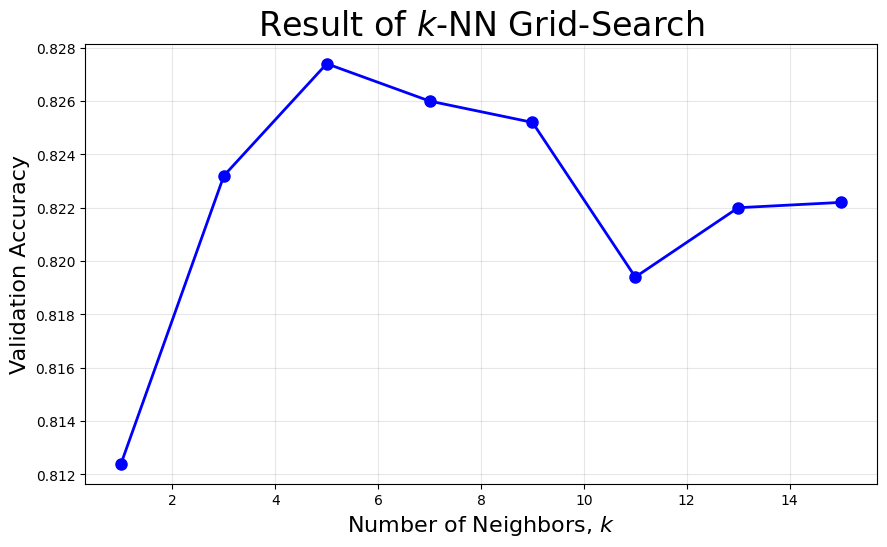

In [8]:
# Plot the accuracy curve as a function of k

fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(top=0.995, bottom=0.115, left=0.005, right=0.995, wspace=0.15, hspace=0.005)

ax0 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)
ax0.plot(k_values, knn_errs_val, "bo-", linewidth=2, markersize=8)
ax0.set_title("Result of $k$-NN Grid-Search", fontsize=24)
ax0.set_xlabel("Number of Neighbors, $k$", fontsize=16)
ax0.set_ylabel("Validation Accuracy", fontsize=16)
ax0.grid(True, alpha=0.3)

In [9]:
# Train the final k-NN model with the best value for k

k_best = k_values[np.argmax(knn_errs_val)]

print(f"The best validation accuracy was {knn_errs_val[np.argmax(knn_errs_val)]:.4f}, found using k={k_best}.")
print(f"\nTraining final k-NN model with k={k_best}...")

# Train on all available training data for best performance
final_train_size = min(Xtrain.shape[0], 30000)  # Use up to 30k samples

model_knn = KNeighborsClassifier(n_neighbors=k_best)
print(f"Fitting on {final_train_size} training samples...")
print(f"Total training samples available: {Xtrain.shape[0]}")
model_knn.fit(Xtrain[:final_train_size, :], ytrain[:final_train_size])

# Evaluate on validation set
final_val_size = Xval.shape[0]  # Use all validation data
err = model_knn.score(Xval[:final_val_size, :], yval[:final_val_size])
print(f"Final validation accuracy: {err:.4f} ({err*100:.2f}%)")
print(f"Training set size used: {final_train_size}")
print(f"Validation set size used: {final_val_size}")

The best validation accuracy was 0.8274, found using k=5.

Training final k-NN model with k=5...
Fitting on 30000 training samples...
Total training samples available: 52500
Final validation accuracy: 0.8493 (84.93%)
Training set size used: 30000
Validation set size used: 8750


### The neural network model

We will use the neural networks (multilayer perceptrons) implemented in scikit-learn. You need to find the optimal number of layers, the number of neurons in each of the layers, and any other hyper-parameters that may be relevant. Again, you may first execute the search with a small subset of the data to make sure it works reasonably well.

#### Neural Network Hyperparameter Search Implementation

The grid search explores multiple dimensions of the neural network architecture:

1. **Network Architecture (hidden_layer_sizes)**:
   - Single hidden layer: (64,), (128,), (256,)
   - Two hidden layers: (64, 32), (128, 64), (256, 128)
   - Three hidden layers: (128, 64, 32), (256, 128, 64)

2. **Learning Rate (learning_rate_init)**:
   - 0.001 (slower, more stable convergence)
   - 0.01 (faster, but may overshoot)

3. **Fixed Parameters**:
   - Activation: ReLU (default)
   - Optimizer: Adam (default)
   - Max iterations: 200 for search, 300 for final model
   - L2 regularization (alpha): 0.0001

**Evaluation Strategy**: Each configuration is trained on a subset of training data and evaluated on validation set to select the best hyperparameters before final training.

In [10]:
# Create the NN classifier and perform grid search

import sklearn.neural_network

print("Starting Neural Network Grid Search...")
print("=" * 60)

# Define hyperparameter search space
# Testing different network architectures
hidden_layer_configs = [
    (64,),  # Single layer with 64 neurons
    (128,),  # Single layer with 128 neurons
    (256,),  # Single layer with 256 neurons
    (64, 32),  # Two layers: 64 -> 32
    (128, 64),  # Two layers: 128 -> 64
    (256, 128),  # Two layers: 256 -> 128
    (128, 64, 32),  # Three layers: 128 -> 64 -> 32
    (256, 128, 64),  # Three layers: 256 -> 128 -> 64
]

# Different learning rates to test
learning_rates = [0.001, 0.01]

# Store results - changed variable name to avoid conflict
nn_errs_val = {}

# Use more data for neural network training
train_subset_size = 30000  # Using 30k training samples
val_subset_size = 5000  # Using 5k validation samples

best_config = None
best_accuracy = 0

# Grid search loops - testing different architectures and learning rates
for hidden_layer_sizes in hidden_layer_configs:
    for learning_rate in learning_rates:

        config_name = f"layers={hidden_layer_sizes}, lr={learning_rate}"
        print(f"\nTesting: {config_name}")

        # Create model with current hyperparameters
        model = sklearn.neural_network.MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            learning_rate_init=learning_rate,
            max_iter=200,  # Maximum number of iterations
            alpha=0.0001,  # L2 regularization parameter
            batch_size="auto",
            random_state=42,
            early_stopping=False,  # We use validation set manually
            verbose=False,
        )

        # Train the model
        print(f"  Training on {train_subset_size} samples...")
        model.fit(Xtrain[:train_subset_size, :], ytrain[:train_subset_size])

        # Evaluate on validation set
        print(f"  Evaluating on {val_subset_size} validation samples...")
        accuracy = model.score(Xval[:val_subset_size, :], yval[:val_subset_size])

        # Store result
        nn_errs_val[(hidden_layer_sizes, learning_rate)] = accuracy

        print(f"  Validation accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  Training iterations: {model.n_iter_}")

        # Track best configuration
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = (hidden_layer_sizes, learning_rate)
            print(f"  *** New best configuration found ***")

print("\n" + "=" * 60)
print("Grid search complete!")
print(f"Best configuration: layers={best_config[0]}, lr={best_config[1]}")
print(f"Best validation accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("=" * 60)

Starting Neural Network Grid Search...

Testing: layers=(64,), lr=0.001
  Training on 30000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8718 (87.18%)
  Training iterations: 169
  *** New best configuration found ***

Testing: layers=(64,), lr=0.01
  Training on 30000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8498 (84.98%)
  Training iterations: 88

Testing: layers=(128,), lr=0.001
  Training on 30000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8814 (88.14%)
  Training iterations: 161
  *** New best configuration found ***

Testing: layers=(128,), lr=0.01
  Training on 30000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8584 (85.84%)
  Training iterations: 130

Testing: layers=(256,), lr=0.001
  Training on 30000 samples...
  Evaluating on 5000 validation samples...
  Validation accuracy: 0.8832 (88.32%)
  Training iterations: 88
  *** New best conf

In [11]:
# Train the final model using the best layer sizes

# Find best configuration from grid search results
best_config_key = max(nn_errs_val, key=nn_errs_val.get)
hidden_layer_sizes_best = best_config_key[0]
learning_rate_best = best_config_key[1]

print(f"The best validation accuracy was {nn_errs_val[best_config_key]:.4f},")
print(f"found using layer sizes: {hidden_layer_sizes_best} and learning rate: {learning_rate_best}")

# Train final model on all available training data
final_train_size = Xtrain.shape[0]  # Use all training data

print(f"\nTraining final ANN model...")
print(f"Configuration: layers={hidden_layer_sizes_best}, lr={learning_rate_best}")
print(f"Total training samples available: {Xtrain.shape[0]}")

model_ann = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes_best, learning_rate_init=learning_rate_best, alpha=0.0001, batch_size="auto", max_iter=300, random_state=42, early_stopping=False, verbose=False  # More iterations for final model
)

print(f"Fitting on {final_train_size} training samples...")
model_ann.fit(Xtrain[:final_train_size, :], ytrain[:final_train_size])

# Evaluate on full validation set
err = model_ann.score(Xval, yval)

print(f"\nFinal validation accuracy: {err:.4f} ({err*100:.2f}%)")
print(f"Training iterations completed: {model_ann.n_iter_}")
print(f"Training set size used: {final_train_size}")
print(f"Validation set size used: {Xval.shape[0]}")

# Check for convergence
if model_ann.n_iter_ >= 300:
    print("Model may not have fully converged (reached max iterations)")
else:
    print("Model converged successfully")

The best validation accuracy was 0.8860,
found using layer sizes: (256, 128, 64) and learning rate: 0.001

Training final ANN model...
Configuration: layers=(256, 128, 64), lr=0.001
Total training samples available: 52500
Fitting on 52500 training samples...

Final validation accuracy: 0.8911 (89.11%)
Training iterations completed: 121
Training set size used: 52500
Validation set size used: 8750
Model converged successfully


Final training loss: 0.029026
Initial training loss: 0.524431
Loss reduction: 94.47%


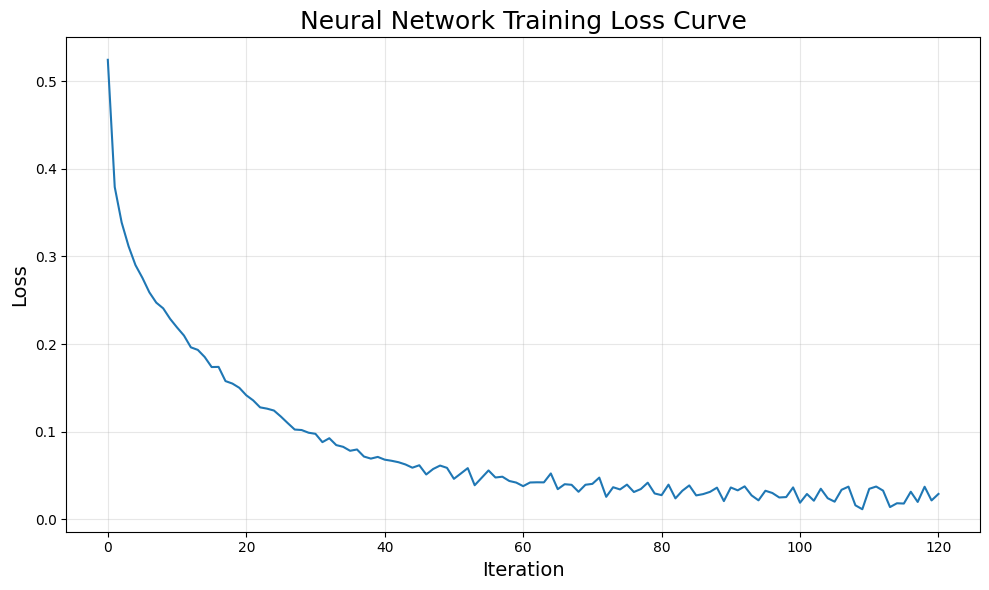

In [12]:
# Plot the training loss curve for the neural network

fig = plt.figure(figsize=(10, 6))
plt.plot(model_ann.loss_curve_)
plt.title("Neural Network Training Loss Curve", fontsize=18)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

print(f"Final training loss: {model_ann.loss_curve_[-1]:.6f}")
print(f"Initial training loss: {model_ann.loss_curve_[0]:.6f}")
print(f"Loss reduction: {((model_ann.loss_curve_[0] - model_ann.loss_curve_[-1]) / model_ann.loss_curve_[0] * 100):.2f}%")

VALIDATION SET PERFORMANCE ANALYSIS

--- k-NN Classifier ---
Validation Accuracy: 0.8493 (84.93%)
Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.86      0.81       862
     Trouser       0.99      0.97      0.98       866
    Pullover       0.73      0.79      0.76       853
       Dress       0.91      0.86      0.89       914
        Coat       0.76      0.77      0.76       891
      Sandal       1.00      0.83      0.90       880
       Shirt       0.63      0.57      0.60       887
     Sneaker       0.89      0.95      0.92       880
         Bag       0.98      0.94      0.96       852
  Ankle boot       0.88      0.97      0.92       865

    accuracy                           0.85      8750
   macro avg       0.85      0.85      0.85      8750
weighted avg       0.85      0.85      0.85      8750


--- Neural Network Classifier ---
Validation Accuracy: 0.8911 (89.11%)
Classification Report:
              precision  

<Figure size 700x600 with 0 Axes>

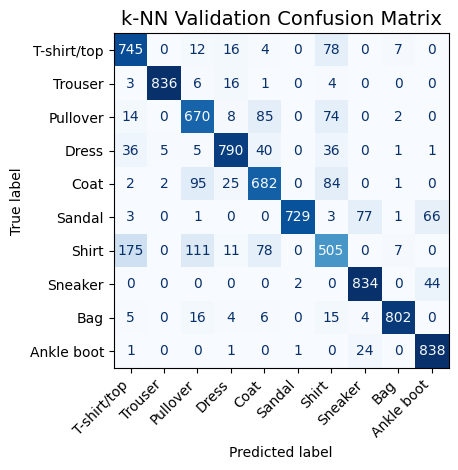

<Figure size 700x600 with 0 Axes>

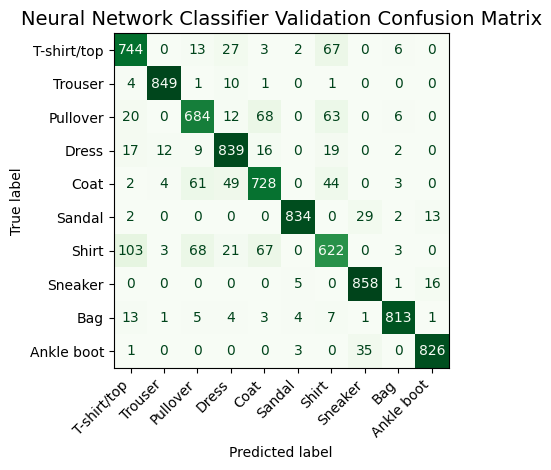

In [13]:
# Display detailed performance metrics

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("=" * 80)
print("VALIDATION SET PERFORMANCE ANALYSIS")
print("=" * 80)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# --- k-NN Classifier ---
print("\n--- k-NN Classifier ---")
knn_val_predictions = model_knn.predict(Xval)
knn_val_accuracy = np.mean(knn_val_predictions == yval)
print(f"Validation Accuracy: {knn_val_accuracy:.4f} ({knn_val_accuracy*100:.2f}%)")
print("Classification Report:")
print(classification_report(yval, knn_val_predictions, target_names=class_names, zero_division=0))

fig = plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(yval, knn_val_predictions, display_labels=class_names, cmap="Blues", colorbar=False)
plt.title("k-NN Validation Confusion Matrix", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# --- Neural Network Classifier ---
ann_model_for_metrics = globals().get("model_ann_final", model_ann)
ann_model_label = globals().get("final_ann_label", "Neural Network Classifier")
print(f"\n--- {ann_model_label} ---")
ann_val_predictions = ann_model_for_metrics.predict(Xval)
ann_val_accuracy = np.mean(ann_val_predictions == yval)
print(f"Validation Accuracy: {ann_val_accuracy:.4f} ({ann_val_accuracy*100:.2f}%)")
print("Classification Report:")
print(classification_report(yval, ann_val_predictions, target_names=class_names, zero_division=0))

fig = plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(yval, ann_val_predictions, display_labels=class_names, cmap="Greens", colorbar=False)
plt.title(f"{ann_model_label} Validation Confusion Matrix", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

print(f"\nClass labels: {class_names}")

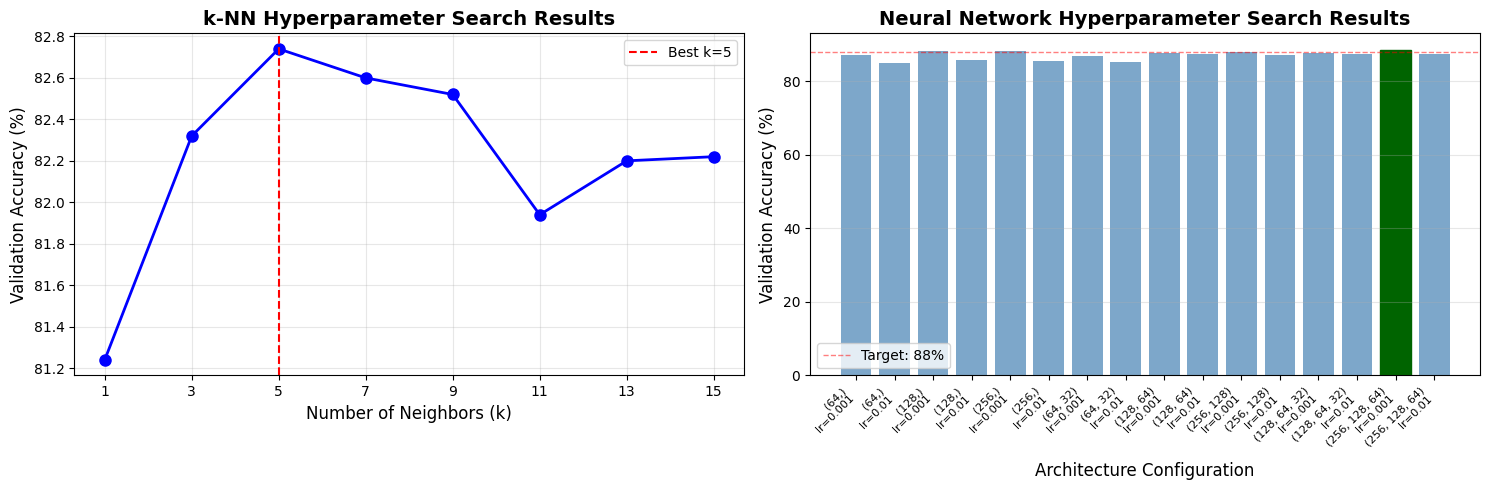


Grid Search Statistics:
k-NN: Best accuracy = 82.74%, Worst accuracy = 81.24%
ANN: Best accuracy = 88.60%, Worst accuracy = 84.98%


In [14]:
# Visualize grid search results comparison

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot k-NN results
ax1.plot(k_values, [acc * 100 for acc in knn_errs_val], "bo-", linewidth=2, markersize=8)
ax1.axvline(x=k_best, color="r", linestyle="--", label=f"Best k={k_best}")
ax1.set_xlabel("Number of Neighbors (k)", fontsize=12)
ax1.set_ylabel("Validation Accuracy (%)", fontsize=12)
ax1.set_title("k-NN Hyperparameter Search Results", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xticks(k_values)

# Plot Neural Network results
nn_configs = list(nn_errs_val.keys())
nn_accuracies = [nn_errs_val[config] * 100 for config in nn_configs]
config_labels = [f"{config[0]}\nlr={config[1]}" for config in nn_configs]

x_pos = range(len(nn_configs))
bars = ax2.bar(x_pos, nn_accuracies, color="steelblue", alpha=0.7)

# Highlight the best configuration
best_idx = nn_accuracies.index(max(nn_accuracies))
bars[best_idx].set_color("darkgreen")
bars[best_idx].set_alpha(1.0)

ax2.set_xlabel("Architecture Configuration", fontsize=12)
ax2.set_ylabel("Validation Accuracy (%)", fontsize=12)
ax2.set_title("Neural Network Hyperparameter Search Results", fontsize=14, fontweight="bold")
ax2.set_xticks(x_pos)
ax2.set_xticklabels(config_labels, rotation=45, ha="right", fontsize=8)
ax2.grid(True, alpha=0.3, axis="y")
ax2.axhline(y=88, color="r", linestyle="--", linewidth=1, alpha=0.5, label="Target: 88%")
ax2.legend()

plt.tight_layout()
plt.show()

print("\nGrid Search Statistics:")
print(f"k-NN: Best accuracy = {max(knn_errs_val) * 100:.2f}%, Worst accuracy = {min(knn_errs_val) * 100:.2f}%")
print(f"ANN: Best accuracy = {max(nn_accuracies):.2f}%, Worst accuracy = {min(nn_accuracies):.2f}%")

In [15]:
# Train a model with stronger regularization to reduce overfitting

print("Training model with stronger regularization...\n")

model_ann_regularized = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    learning_rate_init=0.001,
    alpha=0.001,  # Increased from 0.0001 (10x stronger L2 regularization)
    batch_size='auto',
    max_iter=300,
    random_state=42,
    early_stopping=True,  # Enable early stopping
    validation_fraction=0.1,  # Use 10% of training data for early stopping
    n_iter_no_change=10,  # Stop if no improvement for 10 iterations
    verbose=False
)

print("Fitting regularized model on all training data...")
model_ann_regularized.fit(Xtrain, ytrain)

# Evaluate
train_acc = model_ann_regularized.score(Xtrain, ytrain)
val_acc = model_ann_regularized.score(Xval, yval)

original_train_acc = model_ann.score(Xtrain, ytrain)
original_val_acc = model_ann.score(Xval, yval)

print(f"\nRegularized Model Results:")
print(f"Training accuracy  : {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Train-val gap: {(train_acc - val_acc)*100:.2f}%")
print(f"Training iterations: {model_ann_regularized.n_iter_}")

use_regularized = val_acc >= original_val_acc

model_ann_final = model_ann_regularized
final_ann_label = "Regularized Neural Network"
print("\nSelected model for downstream evaluation: Regularized Neural Network")

model_ann = model_ann_regularized

Training model with stronger regularization...

Fitting regularized model on all training data...

Regularized Model Results:
Training accuracy  : 0.9628 (96.28%)
Validation accuracy: 0.8931 (89.31%)
Train-val gap: 6.96%
Training iterations: 42

Selected model for downstream evaluation: Regularized Neural Network


In [16]:
# Evaluate the final model on all the data sets, including the test data. We
# only evaluate the test data once, and as the last thing we do. If you train
# another model after this, based on the performance on the test data, then your
# test data is effectively a validation dataset, and you no longer have a test
# dataset. (Or, if you keep your test data set, then your results are biased and
# by that unreliable.)

print("=" * 80)
print("FINAL MODEL EVALUATION")
print("=" * 80)

# Determine which neural network variant to evaluate
try:
    model_ann_for_eval = model_ann_final
    ann_eval_label = final_ann_label
except NameError:
    model_ann_for_eval = model_ann
    ann_eval_label = "Neural Network Classifier"

# SET THIS TO TRUE ONLY WHEN WE ARE COMPLETELY DONE WITH MODEL SELECTION
EVALUATE_TEST_SET = True

# Preprocess test data now (only when evaluating)
if EVALUATE_TEST_SET:
    print("\nPreprocessing test data for evaluation...")
    Xtest_scaled = scaler.transform(Xtest)
else:
    print("\nTest data not yet preprocessed (will be done when EVALUATE_TEST_SET=True)")

print("\n--- k-NN CLASSIFIER RESULTS ---")
# Determine how much data to use for evaluation
knn_train_eval_size = min(30000, Xtrain.shape[0])
knn_val_eval_size = Xval.shape[0]

knn_train_acc = model_knn.score(Xtrain[:knn_train_eval_size, :], ytrain[:knn_train_eval_size])
knn_val_acc = model_knn.score(Xval[:knn_val_eval_size, :], yval[:knn_val_eval_size])
print(f"Training data accuracy  : {knn_train_acc:.4f} ({knn_train_acc*100:.2f}%) [n={knn_train_eval_size}]")
print(f"Validation data accuracy: {knn_val_acc:.4f} ({knn_val_acc*100:.2f}%) [n={knn_val_eval_size}]")

# Check for overfitting
if knn_train_acc - knn_val_acc > 0.05:
    print(f"Possible overfitting detected (train-val gap: {(knn_train_acc - knn_val_acc)*100:.2f}%)")

if EVALUATE_TEST_SET:
    knn_test_acc = model_knn.score(Xtest_scaled, ytest)
    print(f"Test data accuracy      : {knn_test_acc:.4f} ({knn_test_acc*100:.2f}%) [n={Xtest.shape[0]}]")
    if knn_test_acc >= 0.84:
        print("k-NN test accuracy meets the requirement (≥84%)")
    else:
        print("k-NN test accuracy does not meet the requirement (≥84%)")
else:
    print("Test data accuracy      : NOT EVALUATED YET (set EVALUATE_TEST_SET=True)")

print(f"\n--- {ann_eval_label.upper()} RESULTS ---")
ann_train_eval_size = Xtrain.shape[0]
ann_val_eval_size = Xval.shape[0]

ann_train_acc = model_ann_for_eval.score(Xtrain[:ann_train_eval_size, :], ytrain[:ann_train_eval_size])
ann_val_acc = model_ann_for_eval.score(Xval[:ann_val_eval_size, :], yval[:ann_val_eval_size])
print(f"Training data accuracy  : {ann_train_acc:.4f} ({ann_train_acc*100:.2f}%) [n={ann_train_eval_size}]")
print(f"Validation data accuracy: {ann_val_acc:.4f} ({ann_val_acc*100:.2f}%) [n={ann_val_eval_size}]")

# Check for overfitting
if ann_train_acc - ann_val_acc > 0.05:
    print(f"Possible overfitting detected (train-val gap: {(ann_train_acc - ann_val_acc)*100:.2f}%)")

if EVALUATE_TEST_SET:
    ann_test_acc = model_ann_for_eval.score(Xtest_scaled, ytest)
    print(f"Test data accuracy      : {ann_test_acc:.4f} ({ann_test_acc*100:.2f}%) [n={Xtest.shape[0]}]")
    if ann_test_acc >= 0.88:
        print("Neural Network test accuracy meets the requirement (≥88%)")
    else:
        print("Neural Network test accuracy does not meet the requirement (≥88%)")
else:
    print("Test data accuracy      : NOT EVALUATED YET (set EVALUATE_TEST_SET=True)")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Training set size: {Xtrain.shape[0]} samples")
print(f"Validation set size: {Xval.shape[0]} samples")
print(f"Test set size: {Xtest.shape[0]} samples")
print(f"\nBest k-NN k value: {k_best}")
print(f"Best ANN architecture: {hidden_layer_sizes_best}")
print(f"Best ANN learning rate: {learning_rate_best}")
print(f"Selected ANN variant for evaluation: {ann_eval_label}")

if EVALUATE_TEST_SET:
    print(f"\nFINAL TEST RESULTS:")
    print(f"  k-NN Test Accuracy: {knn_test_acc*100:.2f}%")
    print(f"  ANN Test Accuracy:  {ann_test_acc*100:.2f}%")
    print(f"  Best Model: {'ANN' if ann_test_acc > knn_test_acc else 'k-NN'}")
print("=" * 80)

FINAL MODEL EVALUATION

Preprocessing test data for evaluation...

--- k-NN CLASSIFIER RESULTS ---
Training data accuracy  : 0.8912 (89.12%) [n=30000]
Validation data accuracy: 0.8493 (84.93%) [n=8750]
Test data accuracy      : 0.8414 (84.14%) [n=8750]
k-NN test accuracy meets the requirement (≥84%)

--- REGULARIZED NEURAL NETWORK RESULTS ---
Training data accuracy  : 0.9628 (96.28%) [n=52500]
Validation data accuracy: 0.8931 (89.31%) [n=8750]
Possible overfitting detected (train-val gap: 6.96%)
Test data accuracy      : 0.8944 (89.44%) [n=8750]
Neural Network test accuracy meets the requirement (≥88%)

SUMMARY
Training set size: 52500 samples
Validation set size: 8750 samples
Test set size: 8750 samples

Best k-NN k value: 5
Best ANN architecture: (256, 128, 64)
Best ANN learning rate: 0.001
Selected ANN variant for evaluation: Regularized Neural Network

FINAL TEST RESULTS:
  k-NN Test Accuracy: 84.14%
  ANN Test Accuracy:  89.44%
  Best Model: ANN
